'ls' is not recognized as an internal or external command,
operable program or batch file.


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random

In [2]:
datadir = 'Data'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

c:\Users\hrutu\.conda\envs\model\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


,center,left,right,steering,throttle,reverse,speed
0,E:\Autonomous Car\Data\IMG\center_2022_05_11_16_55_35_397.jpg,E:\Autonomous Car\Data\IMG\left_2022_05_11_16_55_35_397.jpg,E:\Autonomous Car\Data\IMG\right_2022_05_11_16_55_35_397.jpg,0.0,0.000000,0.0,0.000012
1,E:\Autonomous Car\Data\IMG\center_2022_05_11_16_55_35_444.jpg,E:\Autonomous Car\Data\IMG\left_2022_05_11_16_55_35_444.jpg,E:\Autonomous Car\Data\IMG\right_2022_05_11_16_55_35_444.jpg,0.0,0.000000,0.0,0.000012
2,E:\Autonomous Car\Data\IMG\center_2022_05_11_16_55_35_514.jpg,E:\Autonomous Car\Data\IMG\left_2022_05_11_16_55_35_514.jpg,E:\Autonomous Car\Data\IMG\right_2022_05_11_16_55_35_514.jpg,0.0,0.000000,0.0,0.000003
3,E:\Autonomous Car\Data\IMG\center_2022_05_11_16_55_35_584.jpg,E:\Autonomous Car\Data\IMG\left_2022_05_11_16_55_35_584.jpg,E:\Autonomous Car\Data\IMG\right_2022_05_11_16_55_35_584.jpg,0.0,0.026038,0.0,0.021448
4,E:\Autonomous Car\Data\IMG\center_2022_05_11_16_55_35_652.jpg,E:\Autonomous Car\Data\IMG\left_2022_05_11_16_55_35_652.jpg,E:\Autonomous Car\Data\IMG\right_2022_05_11_16_55_35_652.jpg,0.0,0.256687,0.0,0.197447


In [3]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2022_05_11_16_55_35_397.jpg,left_2022_05_11_16_55_35_397.jpg,right_2022_05_11_16_55_35_397.jpg,0.0,0.000000,0.0,0.000012
1,center_2022_05_11_16_55_35_444.jpg,left_2022_05_11_16_55_35_444.jpg,right_2022_05_11_16_55_35_444.jpg,0.0,0.000000,0.0,0.000012
2,center_2022_05_11_16_55_35_514.jpg,left_2022_05_11_16_55_35_514.jpg,right_2022_05_11_16_55_35_514.jpg,0.0,0.000000,0.0,0.000003
3,center_2022_05_11_16_55_35_584.jpg,left_2022_05_11_16_55_35_584.jpg,right_2022_05_11_16_55_35_584.jpg,0.0,0.026038,0.0,0.021448
4,center_2022_05_11_16_55_35_652.jpg,left_2022_05_11_16_55_35_652.jpg,right_2022_05_11_16_55_35_652.jpg,0.0,0.256687,0.0,0.197447


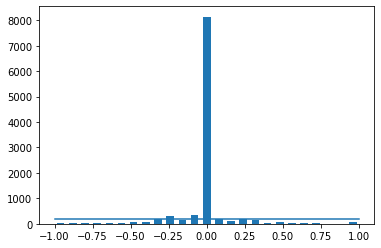

In [4]:
num_bins = 25
samples_per_bin = 200
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

total data: 10377
removed: 8212
remaining: 2165


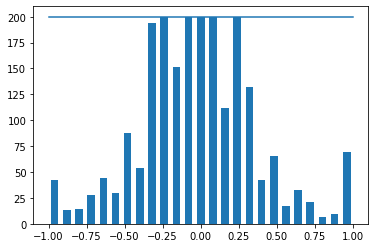

In [5]:
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
 
print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))


In [6]:
print(data.iloc[1])
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
    # left image append
    image_path.append(os.path.join(datadir,left.strip()))
    steering.append(float(indexed_data[3])+0.15)
    # right image append
    image_path.append(os.path.join(datadir,right.strip()))
    steering.append(float(indexed_data[3])-0.15)
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)

center      center_2022_05_11_16_55_36_272.jpg
left        left_2022_05_11_16_55_36_272.jpg  
right       right_2022_05_11_16_55_36_272.jpg 
steering   -0.1                               
throttle    1.0                               
reverse     0.0                               
speed       6.369811                          
Name: 13, dtype: object


In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 5196
Valid Samples: 1299


Text(0.5, 1.0, 'Validation set')

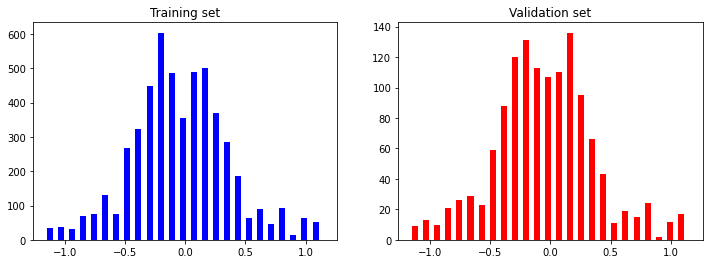

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [9]:
def img_preprocess(img):
    img = mpimg.imread(image)
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img

Text(0.5, 1.0, 'Preprocessed Image')

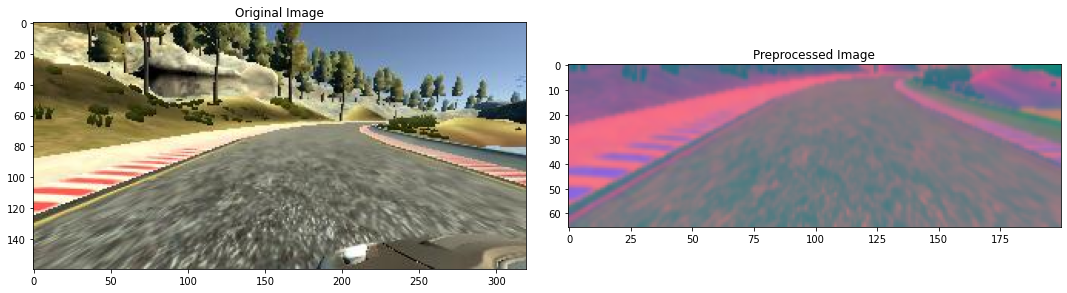

In [10]:
image = image_paths[random.randint(0, len(X_train)-1)]
preprocessed_image = img_preprocess(image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(mpimg.imread(image))
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

In [ ]:
X_train = np.array(list(map(img_preprocess , X_train)))
X_valid = np.array(list(map(img_preprocess , X_valid)))

(6331, 66, 200, 3)


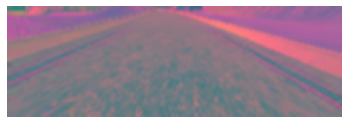

In [ ]:
plt.imshow(X_train[random.randint(0, len(X_train)-1)])
plt.axis('off')
print(X_train.shape)

In [ ]:
def nvidia_model():    
    model= Sequential()
     
    model.add(Convolution2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu'))
    model.add(Convolution2D(36, (5, 5), strides=(2, 2), activation='elu'))
    model.add(Convolution2D(48, (5, 5), strides=(2, 2), activation='elu'))
    model.add(Convolution2D(64, (3, 3), activation='elu'))
    model.add(Convolution2D(64, (3, 3), activation='elu'))
    model.add(Dropout(0.5))
  
    model.add(Flatten())
  
    model.add(Dense(100, activation = 'elu'))
    model.add(Dropout(0.5))
  
    model.add(Dense(50, activation = 'elu'))
    model.add(Dropout(0.5))
  
    model.add(Dense(10, activation = 'elu'))
    model.add(Dropout(0.5))
  
    model.add(Dense(1)) # output the predicted steering angle 
  
    optimizer = Adam(lr=1e-4)
    model.compile(loss='mse', optimizer=optimizer)
    return model


In [ ]:
model = nvidia_model()
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 31, 98, 24)        1824      
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_10 (Conv2D)          (None, 5, 22, 48)         43248     
                                                                 
 conv2d_11 (Conv2D)          (None, 3, 20, 64)         27712     
                                                                 
 conv2d_12 (Conv2D)          (None, 1, 18, 64)         36928     
                                                                 
 dropout_8 (Dropout)         (None, 1, 18, 64)         0         
                                                                 
 flatten_2 (Flatten)         (None, 1152)             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), batch_size=128, verbose=1, shuffle=1)

Epoch 1/30
50/50 [==============================] - 45s 895ms/step - loss: 0.2307 - val_loss: 0.1405
Epoch 2/30
50/50 [==============================] - 44s 874ms/step - loss: 0.1581 - val_loss: 0.1408
Epoch 3/30
50/50 [==============================] - 43s 869ms/step - loss: 0.1528 - val_loss: 0.1405
Epoch 4/30
50/50 [==============================] - 44s 882ms/step - loss: 0.1509 - val_loss: 0.1407
Epoch 5/30
50/50 [==============================] - 44s 880ms/step - loss: 0.1493 - val_loss: 0.1408
Epoch 6/30
50/50 [==============================] - 45s 894ms/step - loss: 0.1505 - val_loss: 0.1405
Epoch 7/30
50/50 [==============================] - 44s 874ms/step - loss: 0.1459 - val_loss: 0.1405
Epoch 8/30
50/50 [==============================] - 44s 873ms/step - loss: 0.1465 - val_loss: 0.1409
Epoch 9/30
50/50 [==============================] - 44s 882ms/step - loss: 0.1453 - val_loss: 0.1410
Epoch 10/30
50/50 [==============================] - 46s 918ms/step - loss: 0.1448 - val_lo

Text(0.5, 0, 'Epoch')

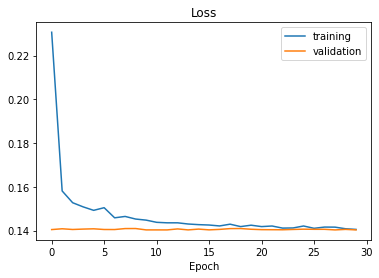

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [ ]:
model.save('model.h5')

In [ ]:
from google.colab import files
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>